# Classification ignition point 

This project is a classification problem

It is to determine whether a point has a probability to be an ignition point for wildfire. The ignition point is where the wildfire starts. To know the probability where a fire would start is central at Descartes because it will help us to better simulate wildfires.

In [351]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency, pointbiserialr
import matplotlib.pyplot as plt 

In [170]:
%reload_ext autoreload
%autoreload 2

# Parameters

In [567]:
DATA_PATH = Path("data")
DATAFRAME_FOLDER_PATH = DATA_PATH / "classification_dataframe"

# 1. Download data

In [706]:
dataframe_path = DATAFRAME_FOLDER_PATH / "dataset.csv"

In [707]:
df = pd.read_csv(dataframe_path,index_col=0)
df.head()

,Date,distance_fire_stations,distance_rivers,distance_roads,distance_powerlines,cropland,forest_deciduous_broad,forest_deciduous_needle,forest_evergreen_broad,forest_evergreen_needle,...,avg_wind_angle,avg_rel_hum,avg_soil,sum_prec,forest,vegetation_class,Year,max_max_temp,yearly_avg_temp,ignition
0,2015-11-19,13287.682266,7211.102551,1250.000000,30196.233209,0.0,0.0,0.0,1.000000,0.0,...,225.773605,56.837185,0.297854,0.360376,1.000000,forest,2015,62.552337,14.994683,1
1,2003-02-17,8721.381771,2358.495283,250.000000,13768.169813,0.0,0.0,0.0,0.416667,0.0,...,209.708847,61.120739,0.264534,0.020176,0.833333,forest,2003,60.787457,15.053698,1
2,2012-02-26,10796.411441,0.000000,2015.564437,6254.998002,0.0,0.0,0.0,0.666667,0.0,...,76.341278,63.017559,0.208871,0.025395,1.000000,forest,2012,63.420256,15.001883,1
3,2004-11-10,8253.787010,559.016994,0.000000,37350.535471,0.0,0.0,0.0,0.000000,0.0,...,68.557823,64.673866,0.156506,0.000000,0.000000,wetland,2004,60.394119,14.850611,1
4,2003-03-19,9905.806378,0.000000,1903.943276,6427.480066,0.0,0.0,0.0,0.750000,0.0,...,316.951508,56.103680,0.208831,0.119717,0.916667,forest,2003,69.570496,NaN,1


## 1.1 Structure of the dataframe and Task


- Each row consists of an ignition or non-ignition point with the given features associated. The features were chosen as potentially influencing ignition.


- The last column named `ignition` says if the point was a real ignition point (meaning that it occurred historically), in that case the value is `1`. Otherwise, when the value is `0`, it means that it is a 'non-ignition point'.


- The columns `cropland` to `wetland` gives the ratio of each of the vegetation classes under which the ignition or non-ignition point lies. The sum of these ratios should be equal to 1. For more information refer to this website: https://lcviewer.vito.be/


- The temperatures should be in degrees celsius `(°C)`.


- The weather data come from different sources and they might have different units.

| Column name | Definition | Unit |
|--------|-----------|--------|
| `ignition`   | Target column| Boolean: {1,0} |
| `distance_{feature}` | Distance to nearest feature  |  Meters (m) |
| vegetation class: from `cropland` to `wetland`  |  Ratio of each of the vegetation classes  under which the ignition or non-ignition point lies    |  No unit (between 0 and 1)  |
| `aspect`  |  Orientation of the slope    |  Degrees (°)  |
| `elevation`  |  elevation value    |  Meters  |
| `slope`  |  Slope value    |  Degrees (°)  |
| `pop_dens`  |  Population density value    |  Persons per km2  |
| `max_temp`  |  Maximum temperature of the day    |  Degrees celsius (°C)  |
| `avg_temp`  |  Average temperature of the day   |  Degrees celsius (°C)  |
| `max_wind_vel`  |  Maximum wind velocity of the day    |  Meters per second (m/s)  |
| `avg_wind_angle`  |  Average angle of the vector wind over the day    |  Degrees (°)  |
| `avg_rel_hum`  |  Average relative humidity over the day    |  %  |
| `avg_soil`  |  Average soil moisture of the day    |  m3/m3  |
| `sum_prec`  |  Cumulative rainfall precipitation of the day    |  Millimeters (mm)  |
| `yearly_avg_temp`  |  Average temperature over the year    |  Degrees celsius (°C)  |
| `anom_{feature}`  |  Standardized anomaly of weather for the given day over the last 30 years. When the anomaly is positive, it means that the feature value is greater that the 30-year average    |  No unity |
| `forest`  |  Sum of all the columns where the names start with `forest`   |  No unit  |
| `vegetation_class`  |  Vegetation with the max occurrence in the vicinity of the ignition/non-ignition point    |  Without unit  |
| `Year`  |  Year of ignition    |  Without unit  |
| `max_max_temp`  |  Missing information    |  Missing information  |


### 2. Exploration of Data

In [708]:
df.shape            ## the shape of data

(22035, 42)

In [709]:
df.dtypes           ### The types of columns 

Date                        object
distance_fire_stations     float64
distance_rivers            float64
distance_roads             float64
distance_powerlines        float64
cropland                   float64
forest_deciduous_broad     float64
forest_deciduous_needle    float64
forest_evergreen_broad     float64
forest_evergreen_needle    float64
forest_mixed               float64
forest_unknown             float64
herbaceous_vegetation      float64
moss_lichen                float64
shrubland                  float64
sprarse_vegetation         float64
urban                      float64
water                      float64
wetland                    float64
aspect                     float64
elevation                  float64
pop_dens                   float64
slope                      float64
anom_max_temp              float64
anom_max_wind_vel          float64
anom_avg_temp              float64
anom_avg_rel_hum           float64
anom_avg_soil              float64
anom_sum_prec       

In [710]:
df.Year.unique()

array([2015, 2003, 2012, 2004, 2002, 2001, 2013, 2016, 2005, 2017, 2008,
       2014, 2009, 2021, 2019, 2018, 2010, 2007, 2020, 2006, 2011],
      dtype=int64)

* Most variables are continuous.
* vegetation_class is a cathegorical variable that must be encoded
* Date variable must transformed to datetime object
* La variable Year ici est vue comme une variable continue.

#### 2.1 Variables Distributuon

In this section, I'll explore variables distribution to get insights on their distribution and variability. This will help me to understand which variables are more significant in my feature model. For better readibility,I'll plot boxplot by lots of variables

Text(0.5, 1.0, 'boxplot')

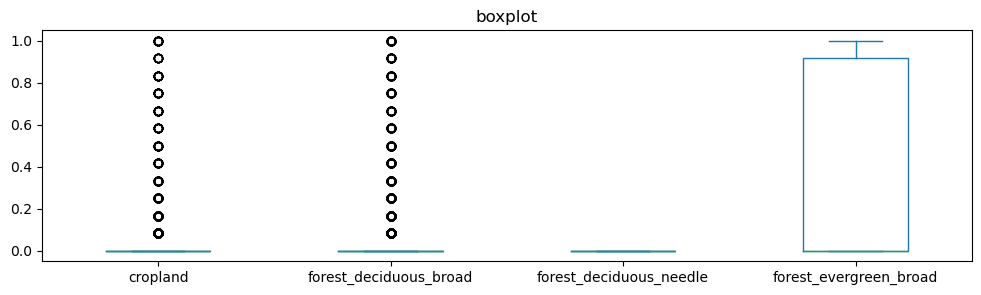

In [711]:
df.iloc[:,5:9].plot(kind = 'box', figsize = (12,3))    
plt.title('boxplot')

In [713]:
df.forest_deciduous_needle.unique()     ### render unique values taken by forest_deciduous_needle

array([ 0., nan])

##### 2.1.1 Conclusion 1


* Variables `cropland`,`forest_deciduous_broad`, `forest_decisuous_needle` have strong concentration around 0 with few outliers values different from 0. 

* This varibales have weak variability and then, will have 0 impact on our future model.
* for `forest_evergreen_broad`, 50% of the sample have values different from 0 and no outliers. This variable can impact more our future model.

we continue to plot the boxplots for the other variables in our dataset.

Text(0.5, 1.0, 'boxplot')

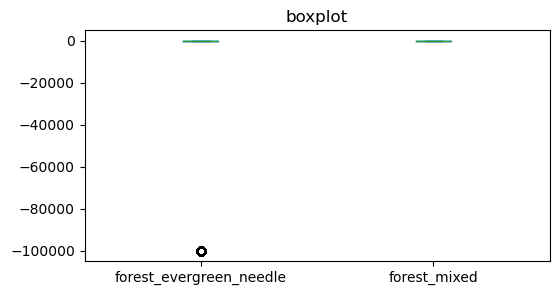

In [714]:
df.iloc[:,9:11].plot(kind = 'box', figsize = (6,3))
plt.title('boxplot')

In [715]:
df.forest_evergreen_needle.unique()       

array([      0., -100000.,      nan])

In [716]:
df.forest_mixed.unique()            

array([ 0., nan])

##### 2.1.2 Conclusion 2

* Variable `forest_evergreen_needle` has a concentration around 0 and a -100000 outliers. 
* Variable `forest_mixed` has also 0 variability.

Same conclusion as previously, this variables has weak variability and will have 0 impact on our feature model. their outliers will just introduce noise and unbiasedness which will prevent our model to generalize correctly. 

Text(0.5, 1.0, 'boxplot')

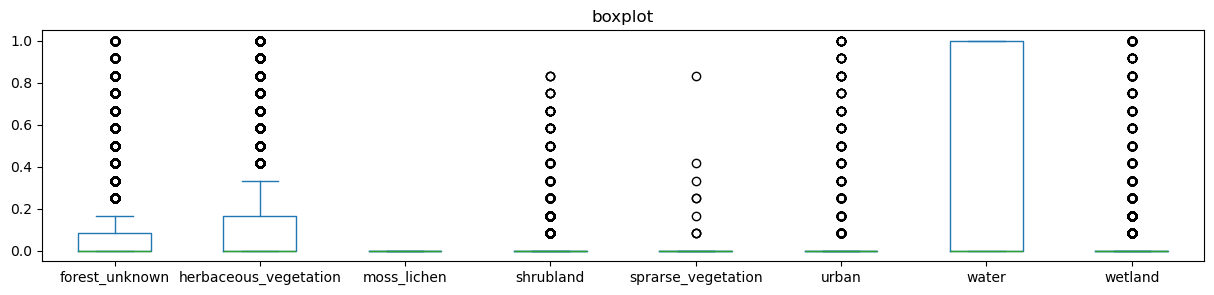

In [717]:
df.iloc[:,11:19].plot(kind = 'box', figsize = (15,3))
plt.title('boxplot')

In [718]:
df.moss_lichen.unique()   

array([ 0., nan])

##### 2.1.3 Conclusion 3

* Same previous Analysis applies on `moss_lichen`,`shrubland`, `sprarse_vegetation`,`urban` and `wetland`

Text(0.5, 1.0, 'boxplot')

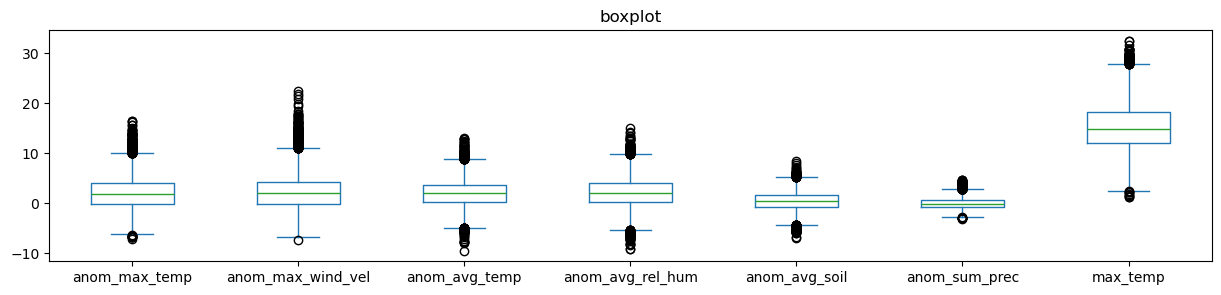

In [719]:
df.iloc[:,23:30].plot(kind = 'box', figsize = (15,3))
plt.title('boxplot')

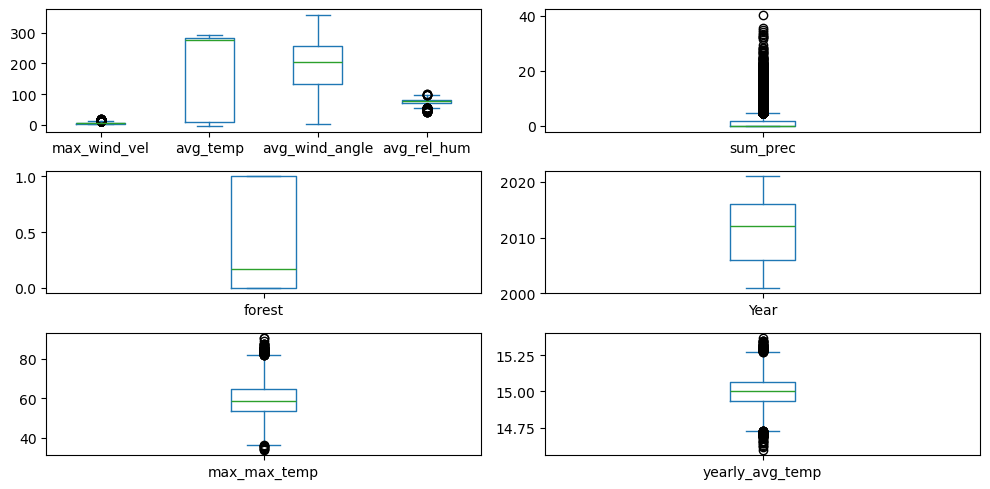

In [720]:
fig, axes = plt.subplots(3,2, figsize = (10,5))

df.iloc[:,30:34].plot(kind = 'box', ax = axes[0,0])
df.iloc[:,35].plot(kind = 'box', ax = axes[0,1])
df.iloc[:,36].plot(kind = 'box',  ax = axes[1,0])
df.iloc[:,38].plot(kind = 'box',ax = axes[1,1])
df.iloc[:,39].plot(kind = 'box',ax = axes[2,0])
df.iloc[:,40].plot(kind = 'box',ax = axes[2,1])

plt.tight_layout()

##### 2.1.4 Conclusion 

* `moss_lichen`,`shrubland`, `sprarse_vegetation`,`urban`, `wetland`, `forest_evergreen_needle`, `forest_mixed`, `cropland`,`forest_deciduous_broad` and `forest_decisuous_needle` will have weak impact on our future classification model.
* Eliminating them will reduce noise and dimentionality of our dataset. 

#### 2.2 Dataset balancedness

In [721]:
balance_df  = df.ignition.value_counts().reset_index() ### verify if the dataset is balanced or unbalanced 
balance_df['portion'] = (balance_df['count']/balance_df['count'].sum())*100
balance_df

,ignition,count,portion
0,0,18715,84.933061
1,1,3320,15.066939


##### Commentary 
Only 15% of our sample are ignition points, the dateset is then unbalanced. we should then:
* use proper metrics in evaluation like precision, recall, F1_Score or Roc_AUC
* Undersampling or oversampling using proper methods. 

#### 2.3 Analyzing the time Pattern in Data 

* The dataset contains a temporal dimension introduced by the variable `Date`
* A point in space is defined by variables starting with "distance_" and the variables `aspect`, `elevation` and `slope`.
* The same spatial point can have different characteristics over time, creating a "Panel Data" structure.
* This temporal variation may violate the assumption of independent and identically distributed (IID) data, which could affect the convergence of estimators in certain algorithms, such as logistic regression.
* To account for this temporal effect, I will introduce a simple approach by adding a temporal variable.
    
    * `Year`: Already exists. This variable may capture long-term temporal trends, such as climate change or evolving agricultural practices. For example, forest fires could become more frequent or severe over time due to global warming.
    * `month`and `season`: The month or season can explain short-term changes in vegetation, weather, and other temporal variations.

In [724]:
dff = df.copy()      ### Create a copy of our dataset

In [725]:
dff['Date'] = pd.to_datetime(dff['Date'])    ### Transform Date variable to Datetime type
dff['month'] = dff['Date'].dt.month        ### Month extraction
dff['season'] = None   

### Creation of seasons.  

dff.loc[dff.month.isin([12, 1,2]), 'season'] = 0            ## winter : 0
dff.loc[dff.month.isin([3, 4,5]), 'season'] = 1           ## Spring: 1
dff.loc[dff.month.isin([6, 7,8]), 'season'] = 2           ## summer: 2
dff.loc[dff.month.isin([9, 10,11]), 'season'] = 3          ## fall: 3

##### 2.3.1 Analyzing the impact of the time Pattern `ignition` on using Cramer's V.   

The choice of Cramer'S V is justified by the fact that Cramér's V is suitable for evaluating the correlation between categorical variables, even with unbalanced frequencies, as it normalizes for table size and accounts for class imbalance.

In [726]:
def V_Cramer(C1,C2):   ### here I define V de Cramer function
    """ 
    C1, C2: np.array ou pandas.series where the values are of both categories are stocked  
    
    """
    # Creation of contingebcy table betweeb A et B
    contingency_table = pd.crosstab(C1, C2)
    
   # Test du Chi-2
    chi2_stat, p, dof, expected = chi2_contingency(contingency_table)

   # Calcul du V de Cramer
    n = np.sum(contingency_table.values)  # Nombre total d'observations
    r, k = contingency_table.shape  # Dimensions du tableau
    cramer_v = np.sqrt(chi2_stat / (n * (min(r, k) - 1)))
   
    return {'V de Cramer' : cramer_v, "P-value" : p}

In [727]:
print(f'CHI 2 Test between ignition and month : {V_Cramer(dff["ignition"], dff["month"])}')
print(f'CHI 2 Test between ignition and season : {V_Cramer(dff["ignition"], dff["season"])}')

CHI 2 Test between ignition and month : {'V de Cramer': 0.02688108993707983, 'P-value': 0.14403868275662055}
CHI 2 Test between ignition and season : {'V de Cramer': 0.008207657656472273, 'P-value': 0.6858749984133248}


##### 2.3.2 Conclusion

* Analysing Cramer's V values, the correlation between `ignition`and `month` or `season` are very weak. Thus,
* `season` and `month` don't provide information about `ignition` in this data. 
* we can then remove them to reduce dimentionnality of our data
* The time Pattern will embedded just in `Year` that we consider as a continuous variable. 

#### 2.4 Analyzing the impact of `vegetation_class`

* We will start by encoding vegetation_class to assess its impact. Initially, I will apply label encoding to check if the `vegetation_class` has an impact on `ignition` using Cramér's V.
* If an impact is observed, I will use one-hot encoding later during modeling to avoid introducing any ordinal relationships between the classes 

In [728]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

dff['vegetation_class_encoded'] = le.fit_transform(dff['vegetation_class'])
 
dff['vegetation_class_encoded'].unique()

array([2, 7, 3, 1, 4, 6, 5, 8, 0])

In [729]:
print(f'CHI 2 Test between ignition and vegetation_class: {V_Cramer(dff["ignition"], dff["vegetation_class_encoded"])}')

CHI 2 Test between ignition and vegetation_class: {'V de Cramer': 0.2593626614058887, 'P-value': 0.0}


##### Conclusion
* we will keep `vegetation_class` variable as the correlation is moderated

#### 2.5 Studying the impact the continuous variables on `ignition`

For correlation between a binary variable (like "ignition" with values 0 and 1) and continuous variables, I will use 
'Point-Biserial' correlation. It's an adapted version of pearson correlation when one of the variables is binary. 

In [730]:
dff = df.dropna()

correlations = {col: pointbiserialr(dff['ignition'], dff[col])[0] for col in dff.select_dtypes(include=['float64', 'int64']).columns}

corr_df = pd.DataFrame(correlations, index=['Point-Biserial']).T

corr_df['Point-Biserial-abs'] = corr_df['Point-Biserial'].abs()

corr_df.dropna().sort_values(by = 'Point-Biserial-abs', ascending = False)

C:\Users\omar.elghaffouli_squ\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


,Point-Biserial,Point-Biserial-abs
ignition,1.000000,1.000000
max_temp,0.303960,0.303960
max_max_temp,0.303960,0.303960
avg_rel_hum,-0.270315,0.270315
distance_roads,-0.269670,0.269670
water,-0.258873,0.258873
distance_fire_stations,-0.228907,0.228907
forest_unknown,0.223377,0.223377
distance_rivers,-0.219555,0.219555
distance_powerlines,-0.211442,0.211442


In [731]:
# max_temp have the same impact on ignition, are they equal ? 
dff.max_temp

0        16.973520
1        15.993032
2        17.455698
3        15.774510
7        22.304850
           ...    
22028     5.704600
22029     9.130116
22031    14.454808
22032    13.846954
22033    12.198812
Name: max_temp, Length: 15181, dtype: float64

In [732]:
dff.max_max_temp

0        62.552337
1        60.787457
2        63.420256
3        60.394119
7        72.148729
           ...    
22028    42.268280
22029    48.434210
22031    58.018655
22032    56.924518
22033    53.957861
Name: max_max_temp, Length: 15181, dtype: float64

In [733]:
# pearson correlation between max_max_temp and max_temp
dff.max_max_temp.corr(dff.max_temp, method = 'pearson')

1.0

`max_max_temp` and `max_temp` are strongly and positively correlated. we will keep just one of them for modeling. 

Next, I will Analyze Pearson correlation between explanatory continuous varibales. I will drop unnecessary continuous variables as expalained in previous sections and also categorical variables because pearson correlation doesn't apply for them. 

In [376]:
df.columns

Index(['Date', 'distance_fire_stations', 'distance_rivers', 'distance_roads',
       'distance_powerlines', 'cropland', 'forest_deciduous_broad',
       'forest_deciduous_needle', 'forest_evergreen_broad',
       'forest_evergreen_needle', 'forest_mixed', 'forest_unknown',
       'herbaceous_vegetation', 'moss_lichen', 'shrubland',
       'sprarse_vegetation', 'urban', 'water', 'wetland', 'aspect',
       'elevation', 'pop_dens', 'slope', 'anom_max_temp', 'anom_max_wind_vel',
       'anom_avg_temp', 'anom_avg_rel_hum', 'anom_avg_soil', 'anom_sum_prec',
       'max_temp', 'max_wind_vel', 'avg_temp', 'avg_wind_angle', 'avg_rel_hum',
       'avg_soil', 'sum_prec', 'forest', 'vegetation_class', 'Year',
       'max_max_temp', 'yearly_avg_temp', 'ignition', 'month', 'season',
       'vegetation_class_encoded'],
      dtype='object')

In [735]:
dfff = dff.drop(['moss_lichen','shrubland', 'sprarse_vegetation','urban', 'wetland', 'forest_evergreen_needle', 
                'forest_mixed', 'cropland','forest_deciduous_broad', 'forest_deciduous_needle', 'Date',
               'vegetation_class', 'ignition'], axis =1)
dfff.head()

,distance_fire_stations,distance_rivers,distance_roads,distance_powerlines,forest_evergreen_broad,forest_unknown,herbaceous_vegetation,water,aspect,elevation,...,max_wind_vel,avg_temp,avg_wind_angle,avg_rel_hum,avg_soil,sum_prec,forest,Year,max_max_temp,yearly_avg_temp
0,13287.682266,7211.102551,1250.000000,30196.233209,1.000000,0.000000,0.000000,0.0,103.793809,835.0,...,5.772759,276.253304,225.773605,56.837185,0.297854,0.360376,1.000000,2015,62.552337,14.994683
1,8721.381771,2358.495283,250.000000,13768.169813,0.416667,0.416667,0.166667,0.0,314.873240,388.0,...,5.706931,3.610960,209.708847,61.120739,0.264534,0.020176,0.833333,2003,60.787457,15.053698
2,10796.411441,0.000000,2015.564437,6254.998002,0.666667,0.333333,0.000000,0.0,189.175183,194.0,...,5.213350,278.800907,76.341278,63.017559,0.208871,0.025395,1.000000,2012,63.420256,15.001883
3,8253.787010,559.016994,0.000000,37350.535471,0.000000,0.000000,0.166667,0.0,153.434949,8.0,...,6.412321,5.787716,68.557823,64.673866,0.156506,0.000000,0.000000,2004,60.394119,14.850611
7,8139.410298,4257.346591,0.000000,3500.000000,0.500000,0.416667,0.000000,0.0,121.860264,431.0,...,6.142017,281.137129,230.412338,60.974873,0.163900,0.142783,0.916667,2013,72.148729,14.980666


In [736]:
### print correlated variables 
dv = dfff.corr(method = 'pearson').unstack().abs().sort_values(ascending=False)
dv[(dv < 1) &(dv>.75)]

forest_evergreen_broad  forest                    0.880938
forest                  forest_evergreen_broad    0.880938
Year                    avg_temp                  0.866019
avg_temp                Year                      0.866019
distance_rivers         distance_roads            0.809852
distance_roads          distance_rivers           0.809852
dtype: float64

#### Conclusion
* Between 2 correlated variables, we will select the one with more impact on `ignition` analyzing Point-Beserial correlation
* `forest_evergreen_broad`, `Year`and `distance_rivers ` will be then removed from our modelization

### 3. Data Preparation 

#### 3.1 Missing Values  

In [737]:
### render total missing values for each columns
df.isna().sum()

Date                          0
distance_fire_stations        5
distance_rivers               5
distance_roads                5
distance_powerlines           5
cropland                      5
forest_deciduous_broad        5
forest_deciduous_needle       5
forest_evergreen_broad        5
forest_evergreen_needle       5
forest_mixed                  5
forest_unknown                5
herbaceous_vegetation         5
moss_lichen                   5
shrubland                     5
sprarse_vegetation            5
urban                         5
water                         5
wetland                       5
aspect                        0
elevation                     0
pop_dens                      0
slope                         0
anom_max_temp                 0
anom_max_wind_vel             0
anom_avg_temp                 0
anom_avg_rel_hum              0
anom_avg_soil                 0
anom_sum_prec                 0
max_temp                      0
max_wind_vel                  0
avg_temp

#### NB: 
* There are a lot of strategies for handeling missing values: removing, replacing by mean, max, min, etc. or even inputation with KNN.
* Here, we will remove missing values. But `yearly_avg_temp` has 6831 missing value. Removing 6831 line will reduce our sample and impact our future model because there will be less available information necessary to converge.
* Analysing previous Point-Beserial correlation between `ignition` and `yearly_avg_temp`, we have 0.012 correlation. which very weak
* Here, we can delete safely `yearly_avg_temp` without impacting considerably the results of our future model.
* NA values of `vegetation_class` will be encoded as a single class
* The reste of missing values will be deleted. 

In [738]:
df.drop('yearly_avg_temp', axis= 1, inplace = True)

In [739]:
df_subset = df.loc[:, df.columns != 'vegetation_class']
df_subset_cleaned = df_subset.dropna()
df = pd.merge(df_subset_cleaned,df[['vegetation_class']], left_index = True, right_index = True, how = 'left')

In [740]:
df.isna().sum()

Date                        0
distance_fire_stations      0
distance_rivers             0
distance_roads              0
distance_powerlines         0
cropland                    0
forest_deciduous_broad      0
forest_deciduous_needle     0
forest_evergreen_broad      0
forest_evergreen_needle     0
forest_mixed                0
forest_unknown              0
herbaceous_vegetation       0
moss_lichen                 0
shrubland                   0
sprarse_vegetation          0
urban                       0
water                       0
wetland                     0
aspect                      0
elevation                   0
pop_dens                    0
slope                       0
anom_max_temp               0
anom_max_wind_vel           0
anom_avg_temp               0
anom_avg_rel_hum            0
anom_avg_soil               0
anom_sum_prec               0
max_temp                    0
max_wind_vel                0
avg_temp                    0
avg_wind_angle              0
avg_rel_hu

#### 3.2 Feature Selection  

Giving previous analysis, `moss_lichen`,`shrubland`, `sprarse_vegetation`,`urban`, `wetland`, `forest_evergreen_needle`, `forest_mixed`, `cropland`,`forest_deciduous_broad`, `forest_decisuous_needle`, `max_max_temp`, `forest_evergreen_broad`, `Year`and `distance_rivers ` for their low variability, correlation, or low impact on `ignition`.

In [741]:
df.drop(['moss_lichen','shrubland', 'sprarse_vegetation','urban', 'wetland', 'forest_evergreen_needle', 
                'forest_mixed', 'cropland','forest_deciduous_broad', 'forest_deciduous_needle', 'Date', 'max_max_temp',
        'forest_evergreen_broad','Year', 'distance_rivers'], axis =1, inplace= True)

In [742]:
correlations = {col: pointbiserialr(df['ignition'], df[col])[0] for col in df.select_dtypes(include=['float64', 'int64']).columns}

corr_dff = pd.DataFrame(correlations, index=['Point-Biserial']).T

corr_dff['Point-Biserial-abs'] = corr_dff['Point-Biserial'].abs()

corr_dff.dropna().sort_values(by = 'Point-Biserial-abs', ascending = False)

,Point-Biserial,Point-Biserial-abs
ignition,1.000000,1.000000
max_temp,0.295061,0.295061
avg_rel_hum,-0.269676,0.269676
distance_roads,-0.268259,0.268259
water,-0.254303,0.254303
distance_fire_stations,-0.228656,0.228656
forest_unknown,0.214991,0.214991
distance_powerlines,-0.205647,0.205647
forest,0.195948,0.195948
anom_avg_soil,-0.193019,0.193019


* I want to keep my model explainable. So performing PCA will make it a black-Box model.
* I will apply PCA only on left variables with | Point-Biserial | < 0.11 to conserve information.
* The other variables will be saved as they are the most variables that explain `ignition`

In [743]:
pca_var = corr_dff.loc[corr_dff['Point-Biserial-abs']<.11].index.values  ### extract variables on which we will apply pca
pca_var

array(['herbaceous_vegetation', 'aspect', 'elevation',
       'anom_max_wind_vel', 'anom_avg_temp', 'anom_sum_prec', 'avg_temp',
       'avg_wind_angle', 'sum_prec'], dtype=object)

In [744]:
df.columns

Index(['distance_fire_stations', 'distance_roads', 'distance_powerlines',
       'forest_unknown', 'herbaceous_vegetation', 'water', 'aspect',
       'elevation', 'pop_dens', 'slope', 'anom_max_temp', 'anom_max_wind_vel',
       'anom_avg_temp', 'anom_avg_rel_hum', 'anom_avg_soil', 'anom_sum_prec',
       'max_temp', 'max_wind_vel', 'avg_temp', 'avg_wind_angle', 'avg_rel_hum',
       'avg_soil', 'sum_prec', 'forest', 'ignition', 'vegetation_class'],
      dtype='object')

In [745]:
from sklearn.preprocessing import OneHotEncoder

encoder  = OneHotEncoder(sparse = False)        ## one hot encoding 

vegetation_class_encoded = encoder.fit_transform(df[['vegetation_class']])

df_vegetation_class_encoded= pd.DataFrame(vegetation_class_encoded, columns=encoder.get_feature_names_out(['vegetation_class']))

df = pd.merge(df,df_vegetation_class_encoded, left_index =True, right_index=True, how='left').drop('vegetation_class', axis=1)

df.head()

C:\Users\omar.elghaffouli_squ\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,distance_fire_stations,distance_roads,distance_powerlines,forest_unknown,herbaceous_vegetation,water,aspect,elevation,pop_dens,slope,...,ignition,vegetation_class_$herb$aceous_vegetation,vegetation_class_Forestt,vegetation_class_forest,vegetation_class_herbaceous_vegetation,vegetation_class_shrubland,vegetation_class_urban,vegetation_class_water,vegetation_class_wetland,vegetation_class_nan
0,13287.682266,1250.000000,30196.233209,0.000000,0.000000,0.0,103.793809,835.0,0.709305,3.213570,...,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8721.381771,250.000000,13768.169813,0.416667,0.166667,0.0,314.873240,388.0,2.509037,7.861014,...,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10796.411441,2015.564437,6254.998002,0.333333,0.000000,0.0,189.175183,194.0,0.395425,2.441008,...,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8253.787010,0.000000,37350.535471,0.000000,0.166667,0.0,153.434949,8.0,0.524736,1.438359,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,9905.806378,1903.943276,6427.480066,0.166667,0.083333,0.0,304.397387,216.0,0.719442,11.403785,...,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [746]:
df[df.isna().any(axis=1)]

,distance_fire_stations,distance_roads,distance_powerlines,forest_unknown,herbaceous_vegetation,water,aspect,elevation,pop_dens,slope,...,ignition,vegetation_class_$herb$aceous_vegetation,vegetation_class_Forestt,vegetation_class_forest,vegetation_class_herbaceous_vegetation,vegetation_class_shrubland,vegetation_class_urban,vegetation_class_water,vegetation_class_wetland,vegetation_class_nan
22030,12260.199835,500.000000,39374.007924,0.0,0.0,1.0,180.000000,-100.0,1.123672,0.000000,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22031,8933.784193,790.569415,40380.998006,0.0,0.0,0.0,94.455603,70.0,1.374221,4.983265,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22032,56560.255480,6388.466170,23538.532240,0.0,0.0,0.0,135.574855,307.0,0.000000,10.798985,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22033,94191.294715,14637.281168,83236.485390,0.0,0.0,1.0,180.000000,-100.0,0.000000,0.000000,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22034,41926.274578,3092.329219,39957.790229,0.0,0.5,0.5,37.950822,7.0,0.000000,2.121468,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [747]:
df.dropna(inplace=True)

In [748]:
### first, we will split our data into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('ignition', axis =1), df['ignition'],test_size = .25, random_state=33)

cat_X_train = X_train.iloc[:,-9:]   # because stardization doesn't support cat variables, we will extract and add them later
cat_X_test = X_test.iloc[:,-9:]

continuous_X_train = X_train.loc[:, ~ X_train.columns.isin(cat_X_train.columns)]
continuous_X_test = X_test.loc[:, ~ X_test.columns.isin(cat_X_test.columns)]

#### 3.3. PCA

In [749]:
### we will standardize our continuous variables  for pca

from sklearn.preprocessing import StandardScaler

scaler_1 =  StandardScaler().fit(continuous_X_train)   ### it fits only on train (mean and standard dev of train only)

continuous_X_train_normalized_1  = scaler_1.transform(continuous_X_train )
continuous_X_test_normalized_1 = scaler_1.transform(continuous_X_test)

In [750]:
### get the desired features for pca 
dico ={}
i=0
for e in X_train.columns:
    dico[e] = i
    i+=1
dico_2 = {}
for e in pca_var:
    dico_2[e] = dico[e]
dico_2    

{'herbaceous_vegetation': 4,
 'aspect': 6,
 'elevation': 7,
 'anom_max_wind_vel': 11,
 'anom_avg_temp': 12,
 'anom_sum_prec': 15,
 'avg_temp': 18,
 'avg_wind_angle': 19,
 'sum_prec': 22}

In [751]:
### get the desired features for pca 
continuous_X_train_pca = continuous_X_train_normalized_1[:, [4,6,7,11,12,15,18,19,22]]   ### extract columns on which we will apply pca
continuous_X_test_pca = continuous_X_test_normalized_1[:, [4,6,7,11,12,15,18,19,22]]

In [752]:
### Apply PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=9).fit(continuous_X_train_pca)
pca_result_train = pca.transform(continuous_X_train_pca)
pca_result_test = pca.transform(continuous_X_test_pca)

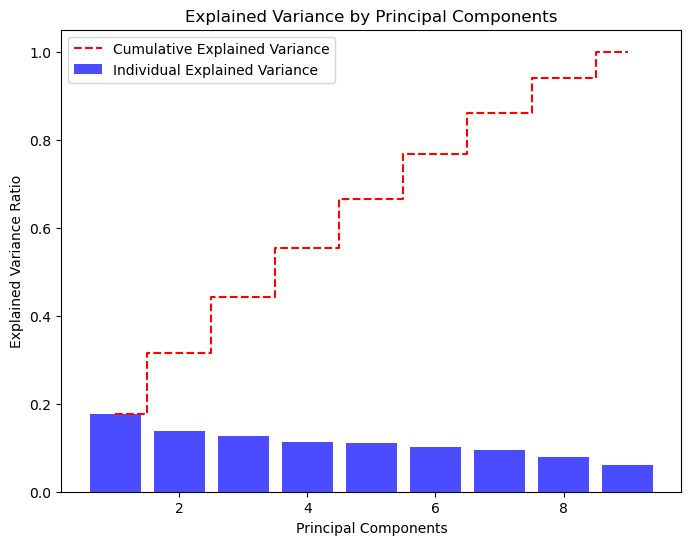

In [753]:
# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance for each component
plt.figure(figsize=(8,6))
plt.bar(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, alpha=0.7, align='center', color='b', label='Individual Explained Variance')
plt.step(range(1, len(explained_variance_ratio)+1), explained_variance_ratio.cumsum(), where='mid', linestyle='--', color='r', label='Cumulative Explained Variance')

# Add labels and title
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.show()

In this case, PCA is not very useful. Because, we don't have a component that explains most of the variance in our selected features. 

Next, we will just remove variables that verifies | Point-Biserial | < 0.11 which are :  `herbaceous_vegetation`, `aspect`,`elevation`,`anom_max_wind_vel`,`anom_avg_temp`, `avg_temp`, `avg_wind_angle`, `sum_prec`.

In [754]:
continuous_X_train_ = continuous_X_train.loc[:,~continuous_X_train.columns.isin(pca_var)]
continuous_X_test_ = continuous_X_test.loc[:,~continuous_X_test.columns.isin(pca_var)]


scaler_2 =  StandardScaler().fit(continuous_X_train_)   

continuous_X_train_normalized_2  = scaler_2.transform(continuous_X_train_)
continuous_X_test_normalized_2 = scaler_2.transform(continuous_X_test_)

In [755]:
train_x = np.concatenate([continuous_X_train_normalized_2, cat_X_train.values], axis=1)
test_x = np.concatenate([continuous_X_test_normalized_2, cat_X_test.values], axis=1)
train_y = y_train.values
test_y = y_test.values

In [756]:
y_train.value_counts()

ignition
0    14067
1     2451
Name: count, dtype: int64

### 4. Modeling & Evaluation

In [768]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve
perf_dico = {}

#### 4.1 Logistic Regression

In [767]:
from sklearn.linear_model import LogisticRegression

### Fitting

log_reg = LogisticRegression(max_iter=10000)  
log_reg.fit(train_x , train_y)

### Predictions
y_pred_lr = log_reg.predict(test_x)
y_pred_proba_lr = log_reg.predict_proba(test_x)[:, 1]  # Probabilities for ROC-AUC

### metrics for unbalanced data

roc_auc_lr = roc_auc_score(test_y, y_pred_proba_lr)   ### The roc auc is adapted for unblanaced data + it doesn't depend on a specific treshhold 

precision_lr = precision_score(test_y, y_pred_lr)

recall_lr = recall_score(test_y, y_pred_lr)


# Display the metrics

print(f"ROC-AUC Score: {round(roc_auc_lr, 3)}")

ROC-AUC Score: 0.897


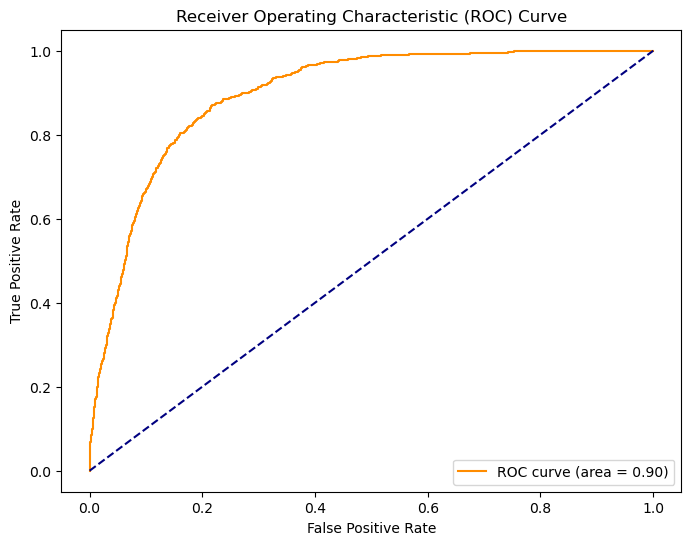

In [759]:
### let's plot the roc curve 
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### 4.1.1. Analysis 1 

The Roc Auc is the best metric here because it doesn't depend on a specific treshold to split classes based on the probability and also it is adapted for unbalanced dataset.  

Next, we will look for the best treshold that maximize the precision and the recall. 

In [642]:
# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(test_y, y_pred_proba)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

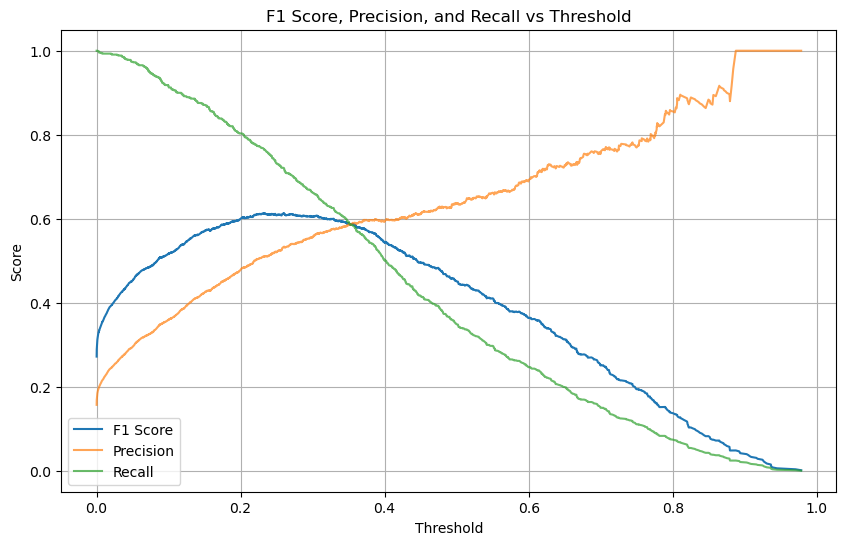

In [647]:
# Plot F1 Score, Precision, and Recall against thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.plot(thresholds, precision[:-1], label='Precision', alpha=0.7)
plt.plot(thresholds, recall[:-1], label='Recall', alpha=0.7)

# Highlight the optimal threshold
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1 Score, Precision, and Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

##### 4.1.2. Analysis 2

The roc auc is around 0.9 which is treshold independant. Depends on the purpose of our model; we will: 
 * Choose the treshold with the highest precision, the model will predict correcly all ignition points at a high precision.
 * Choose the treshold with the highest recall, the model will predict correcly all non-ignition points at a high precision.
 * Choose the treshold that maximizes the trade off between precision and recall which is the F1 Score.  

##### 4.1.3. Explainability

In [688]:
coefficients = log_reg.coef_[0] 
coefficients

array([-0.18180094, -2.20351588, -0.43516881,  0.19906606, -0.03100665,
        0.10050626,  0.22457812,  0.03820549,  0.07811869, -0.30261128,
        0.4426725 ,  0.23576596, -0.39679566, -0.18826646,  0.00609284,
       -0.05276199,  0.44212625,  0.45513413,  0.23545794,  0.47537752,
        0.10334894, -1.38396753,  0.71729732, -0.99993938])

In [701]:
coef_df = pd.DataFrame({
    'Feature': pd.concat([continuous_X_train_, cat_X_train], axis=1).columns,
    'Coefficient': coefficients
})
coef_df['Coefficient_ABS'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Coefficient_ABS', ascending=False)
coef_df 

,Feature,Coefficient,Coefficient_ABS
1,distance_roads,-2.203516,2.203516
21,vegetation_class_water,-1.383968,1.383968
23,vegetation_class_nan,-0.999939,0.999939
22,vegetation_class_wetland,0.717297,0.717297
19,vegetation_class_shrubland,0.475378,0.475378
17,vegetation_class_forest,0.455134,0.455134
10,max_temp,0.442673,0.442673
16,vegetation_class_Forestt,0.442126,0.442126
2,distance_powerlines,-0.435169,0.435169
12,avg_rel_hum,-0.396796,0.396796


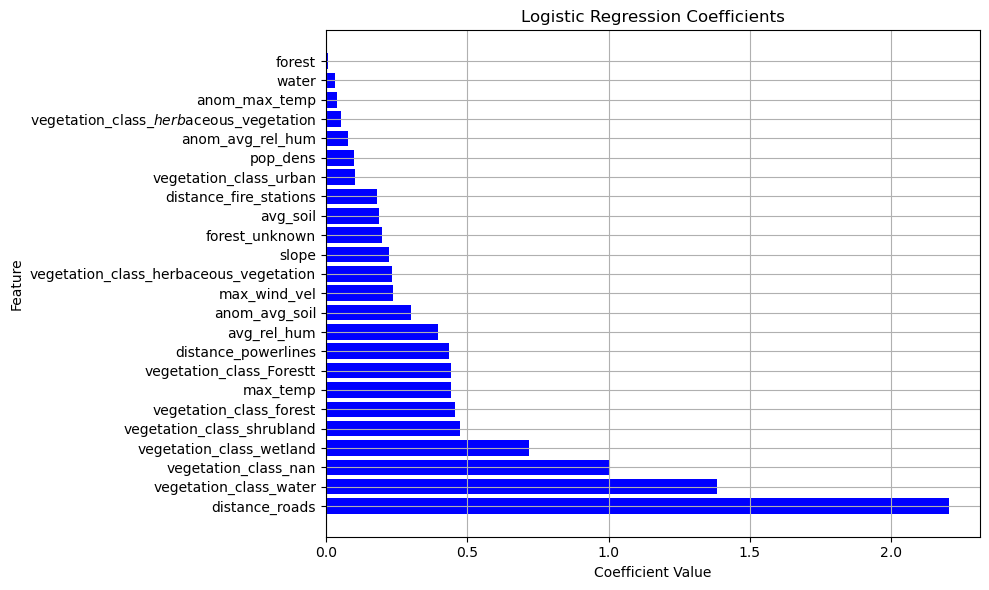

In [703]:
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient_ABS'], color='b')  # Horizontal bar plot
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.grid(True)
plt.tight_layout()
plt.show()

In [705]:
 pd.concat([continuous_X_train_, cat_X_train], axis=1).columns

Index(['distance_fire_stations', 'distance_roads', 'distance_powerlines',
       'forest_unknown', 'water', 'pop_dens', 'slope', 'anom_max_temp',
       'anom_avg_rel_hum', 'anom_avg_soil', 'max_temp', 'max_wind_vel',
       'avg_rel_hum', 'avg_soil', 'forest',
       'vegetation_class_$herb$aceous_vegetation', 'vegetation_class_Forestt',
       'vegetation_class_forest', 'vegetation_class_herbaceous_vegetation',
       'vegetation_class_shrubland', 'vegetation_class_urban',
       'vegetation_class_water', 'vegetation_class_wetland',
       'vegetation_class_nan'],
      dtype='object')

##### Model interpretation

* Like the point beserial correlation analysis performed in feature selection section, `distance_roads` `max_temp` and `distance_powerlines` are variables with the bigest weight in our logistic regression model among the continuous variables.

* `vegetation_class_{class}` have also the bigest weight in the logistic regression and thus, explain the most the ignition decision

#### 4.2. Decision Tree 

In [765]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

# Initialize Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)

# Fit the model
dt_clf.fit(train_x, train_y)

# Make predictions
y_pred_dt = dt_clf.predict(test_x)
y_pred_proba_dt = dt_clf.predict_proba(test_x)[:, 1]  # Probabilities for ROC-AUC

# Compute ROC-AUC score (adapted for unbalanced data)
roc_auc_dt = roc_auc_score(test_y, y_pred_proba_dt)

precision_dt = precision_score(test_y, y_pred_dt)

recall_dt = recall_score(test_y, y_pred_dt)

# Display the ROC-AUC score
print(f"Decision Tree ROC-AUC Score: {round(roc_auc_dt, 3)}")

Decision Tree ROC-AUC Score: 0.761


#### 4.3 Random Forest - Bagging

In [764]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)


rf_clf.fit(train_x, train_y)


y_pred_rf = rf_clf.predict(test_x)
y_pred_proba_rf = rf_clf.predict_proba(test_x)[:, 1]  # Probabilities for ROC-AUC


roc_auc_rf = roc_auc_score(test_y, y_pred_proba_rf)

precision_rf = precision_score(test_y, y_pred_rf)

recall_rf = recall_score(test_y,y_pred_rf)


print(f"Random Forest ROC-AUC Score: {round(roc_auc_rf, 3)}")

Random Forest ROC-AUC Score: 0.953


#### 4.4 Gradient Boosting- Boosting

In [766]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

# Initialize Gradient Boosting
gb_clf = GradientBoostingClassifier(random_state=42)

# Fit the model
gb_clf.fit(train_x, train_y)

# Make predictions
y_pred_gb = gb_clf.predict(test_x)
y_pred_proba_gb = gb_clf.predict_proba(test_x)[:, 1]  # Probabilities for ROC-AUC

# Compute ROC-AUC score (adapted for unbalanced data)
roc_auc_gb = roc_auc_score(test_y, y_pred_proba_gb)

precision_gb  = precision_score(test_y, y_pred_gb )

recall_gb  = recall_score(test_y,y_pred_gb )

# Display the ROC-AUC score
print(f"Gradient Boosting ROC-AUC Score: {round(roc_auc_gb, 3)}")

Gradient Boosting ROC-AUC Score: 0.944


#### 4.4. Conclusion  

In [769]:
perf_dico['ROC_AUC'] = [roc_auc_lr,roc_auc_dt, roc_auc_rf, roc_auc_gb]
perf_dico['Precision'] = [precision_lr,precision_dt, precision_rf, precision_gb]
perf_dico['Recall'] = [recall_lr,recall_dt, recall_rf, recall_gb]

In [771]:
df = pd.DataFrame(perf_dico, index = ['Logistic Regression','Decision Tree', 'Random Forest', 'Gradient Boosting' ])
df

,ROC_AUC,Precision,Recall
Logistic Regression,0.897112,0.636555,0.348677
Decision Tree,0.761390,0.603730,0.596087
Random Forest,0.953044,0.791118,0.553510
Gradient Boosting,0.943895,0.716463,0.540852


* Because, we have unbalanced data, accuracy is not the proper metric
* Roc Auc, precision and recall are complementary metrics that should carefully be analyzed.
* If we want to maximize the precision of our forecast, which means the model predicts ignition (1) at a high certainty, random forest is the best model. 